In [46]:
import scipy.optimize
import pandas
import numpy as np
import matplotlib.pyplot as plt

In [5]:
df = pandas.read_csv('Step1.csv')
ydata = df.T1.values
udata = df.Q1.values
time = df.Time.values

## I'm identifying the parameters of an ARX model using differential evolution.

In [68]:
# The objective function

def OF(x):
    a1, a2, b1, b2 = x
    yt = []
    for i, it in enumerate(time):
        if i-1<0:
            y1 = ydata[0]
            u1 = udata[0]
        else:
            y1 = ydata[i-1]
            u1 = udata[i-1]
        if i-2<0:
            y2 = ydata[0]
            u2 = udata[0]
        else:
            y2 = ydata[i-2]
            u2 = udata[i-2]
        yt.append(a1*y1 + a2*y2 + b1*u1 + b2*u2)
    
    return sum((ydata - yt)**2)

In [36]:
# Differential Evolution.

bnds = ((0,1), (0,1), (0,1), (0,1))
scipy.optimize.differential_evolution(OF, bounds=bnds)

     fun: 16.009488649780057
     jac: array([ 0.22022917,  0.22103919, -0.07813483, -0.12744223])
 message: 'Optimization terminated successfully.'
    nfev: 3635
     nit: 57
 success: True
       x: array([0.54322843, 0.45104887, 0.00240761, 0.00375616])

### Unforunately error^2 is quite large ... therefore the error is 4 here.

In [38]:
# Comparison with minimize.

Xo = [0.9799079, 0.01606574, 0.001687, 0.00264688]
scipy.optimize.minimize(OF, Xo)

      fun: 16.00948807224082
 hess_inv: array([[ 5.41999339e-01, -5.55212401e-01,  6.40450563e-03,
         5.53902275e-03],
       [-5.55212401e-01,  5.68748109e-01, -6.56042080e-03,
        -5.67468385e-03],
       [ 6.40450563e-03, -6.56042080e-03,  2.75358294e-04,
        -1.34462981e-04],
       [ 5.53902275e-03, -5.67468385e-03, -1.34462981e-04,
         2.57273789e-04]])
      jac: array([-5.24520874e-05, -4.91142273e-05,  3.21865082e-05,  3.19480896e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 260
      nit: 11
     njev: 42
   status: 2
  success: False
        x: array([0.54321525, 0.45105994, 0.00239863, 0.00376711])

### Not sure why this optimization isn't successful, yet the same values for a1, a2, b1 and b2 are determined as in differential evolution.

## Calculating Predictions

In [82]:
# Step response
a1, a2, b1, b2 = 0.54321525, 0.45105994, 0.00239863, 0.00376711
lstsq = [0.9799079,0.01606574,0.001687,0.00264688]
y_difev = []
us = []
y_0 = y_1 = y_2 = ydata[0]
for i, ti in enumerate(time):
    u_1 = 0 if i < 1 else udata[i-1]
    u_2 = 0 if i < 2 else udata[i-2]
    y_2, y_1 = y_1, y_0
    y_0 = a1*y_1 + a2*y_2 + b1*u_1 + b2*u_2
    us.append([u_1, u_2])
    y_difev.append(y_0)

y_difev = np.array(y_difev) 


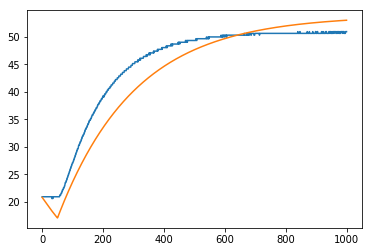

In [72]:
plt.plot(time, ydata)
plt.plot(time, y_difev)